# Installations

In [1]:
import random
import math
import json
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML, clear_output
from geopy.distance import geodesic

# Data Preparation

In [2]:
!git clone https://github.com/hflabs/city

clear_output()

In [3]:
city = pd.read_csv('city/city.csv')

city.head(1)

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969


In [4]:
data = city[['city', 'geo_lat', 'geo_lon', 'population']]

data.head()

,city,geo_lat,geo_lon,population
0,Адыгейск,44.878414,39.190289,12689
1,Майкоп,44.609827,40.100661,144055
2,Горно-Алтайск,51.958103,85.960324,62861
3,Алейск,52.492251,82.779361,28528
4,Барнаул,53.347997,83.779806,635585


In [5]:
data = data.sort_values(by=['population'], ascending=False)[:30]

data

,city,geo_lat,geo_lon,population
509,NaN,55.754047,37.620405,11514330
786,NaN,59.939131,30.315900,4848742
647,Новосибирск,55.028191,82.921149,1498921
832,Екатеринбург,56.838522,60.605491,1377738
619,Нижний Новгород,56.324063,44.005391,1250615
927,Казань,55.794358,49.111497,1216965
782,Самара,53.195031,50.106952,1164900
656,Омск,54.984857,73.367452,1154000
1064,Челябинск,55.160262,61.400808,1130273
757,Ростов-на-Дону,47.222457,39.718803,1091544


In [6]:
data = data.drop(['population'], axis=1)

data.at[509, 'city'] = "Москва"
data.at[786, 'city'] = "Санкт-Петербург"

data

,city,geo_lat,geo_lon
509,Москва,55.754047,37.620405
786,Санкт-Петербург,59.939131,30.315900
647,Новосибирск,55.028191,82.921149
832,Екатеринбург,56.838522,60.605491
619,Нижний Новгород,56.324063,44.005391
927,Казань,55.794358,49.111497
782,Самара,53.195031,50.106952
656,Омск,54.984857,73.367452
1064,Челябинск,55.160262,61.400808
757,Ростов-на-Дону,47.222457,39.718803


In [7]:
cities = list(data['city'].unique())

n = len(cities)

lat_lon = data[['geo_lat', 'geo_lon']].to_numpy()

distance_matrix = np.zeros((n, n))

for i in range(n):
  coords1 = (lat_lon[i][0], lat_lon[i][1])
  for j in range(n):
    coords2 = (lat_lon[j][0], lat_lon[j][1])

    d = round(geodesic(coords1, coords2).km, 1)

    distance_matrix[i][j] = d

# Simulated Annealing

In [8]:
def correct_route(x):
  return x+[x[0]]

In [9]:
# proposal distribution
def g(x):
  two_elems = random.sample(x, 2)
  
  index1 = x.index(two_elems[0])
  index2 = x.index(two_elems[1])

  x[index1] = two_elems[1]
  x[index2] = two_elems[0]

  return x

In [10]:
# path distance
def dist(x):

  correct_x = correct_route(list(x))

  distance = 0

  for i in range(len(correct_x)-1):
    city1 = correct_x[i]
    city2 = correct_x[i+1]

    index1 = cities.index(city1)
    index2 = cities.index(city2)

    distance += distance_matrix[index1][index2]

  return distance

In [11]:
# energy distribution
def p(x, T):
  return math.exp(-dist(x)/T)

In [12]:
# temperature annealing
def temp(T, alpha):
  return T*alpha

In [13]:
def sa(x_t, T_t, t, alpha):

  x_dash = g(list(x_t))

  try:
    acceptance_ratio = p(x_dash, T_t)/p(x_t, T_t)
  except ZeroDivisionError:
    acceptance_ratio = 0
    
  u = np.random.uniform()

  if u <= acceptance_ratio:
    x_t1 = x_dash
  else:
    x_t1 = x_t

  T_t1 = temp(T_t, alpha)

  t1 = t+1

  return x_t1, T_t1, t1

In [14]:
def main(T_t, alpha):

  results = []

  x_t = np.random.permutation(cities)

  t = 0

  while T_t > 1:
    results.append((x_t, T_t))
    x_t, T_t, t = sa(x_t, T_t, t, alpha)

  return results

In [15]:
T_initial = 10000
annealing_rate = 0.99

output = main(T_initial, annealing_rate)

# Convergence

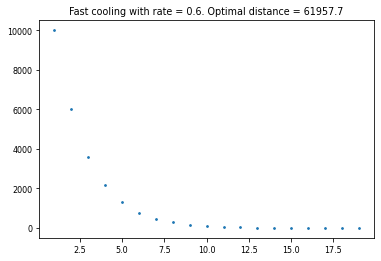

In [28]:
n = []
m = []

ar = 0.6
out = main(T_initial, ar)

for i in range(len(out)):
  n.append(i+1)
  m.append(out[i][1])

plt.scatter(n, m, s=3)
plt.title("Fast cooling with rate = {}. Optimal distance = {}".format(ar, round(dist(out[-1][0]), 1)))
plt.show()

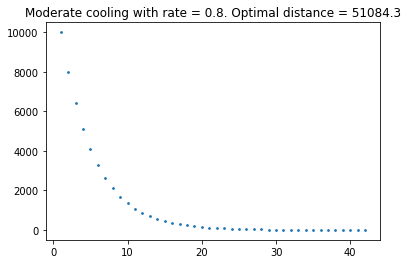

In [17]:
n = []
m = []

ar = 0.8
out = main(T_initial, ar)

for i in range(len(out)):
  n.append(i+1)
  m.append(out[i][1])

plt.scatter(n, m, s=3)
plt.title("Moderate cooling with rate = {}. Optimal distance = {}".format(ar, round(dist(out[-1][0]), 1)))
plt.show()

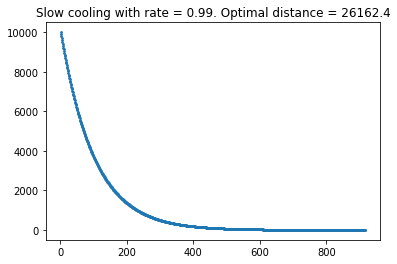

In [18]:
n = []
m = []

ar = 0.99
out = main(T_initial, ar)

for i in range(len(out)):
  n.append(i+1)
  m.append(out[i][1])

plt.scatter(n, m, s=3)
plt.title("Slow cooling with rate = {}. Optimal distance = {}".format(ar, round(dist(out[-1][0]), 1)))
plt.show()

# Animation

### Country outline

In [19]:
urllib.request.urlretrieve("https://www.dropbox.com/s/sadvwkzbqjjurdv/russia.json?dl=1", "russia.json")

clear_output()

In [20]:
with open("russia.json", 'rb') as file:
  outline = json.load(file)

In [21]:
coordinates = outline[0]['geojson']['coordinates']

In [22]:
squeezed_coordinates = np.squeeze(coordinates)

clear_output()

In [23]:
all_coords = []

for a in squeezed_coordinates:
  for b in a:
    if b[0] < 0:
      b[0] *= -1
    all_coords.append(b)

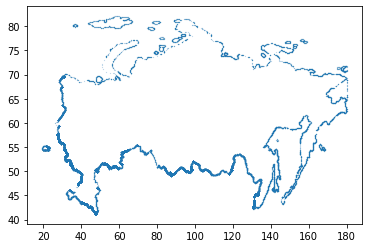

In [24]:
k = [i[0] for i in all_coords]
r = [i[1] for i in all_coords]

plt.scatter(k, r, s=0.01)
plt.show()

### Visualization

In [25]:
x = [i[0] for i in lat_lon]
y = [i[1] for i in lat_lon]

fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 8})
fig.set_size_inches(18, 12)

plt.close()

In [32]:
def animate(i):
    xs = []
    ys = []
 
    path = output[i][0]
    correct_path = correct_route(list(path))
    temperature = output[i][1]
    d = dist(correct_path)

    for j in range(len(correct_path)):
      city = correct_path[j]

      index = cities.index(city)

      xs.append(x[index])
      ys.append(y[index])
 
    ax.clear()
    ax.plot(ys, xs, linewidth=1, color='green')
    ax.scatter(k, r, s=0.05)
    ax.set_axis_off()

    for j, txt in enumerate(cities):
      ax.annotate(txt, (y[j], x[j]))

    ax.set_title('T = {}, Optimal distance = {}'.format(round(temperature, 1), round(d, 1)))

In [34]:
ani = animation.FuncAnimation(fig, animate, frames=len(output), interval=100)

In [35]:
HTML(ani.to_html5_video())

Text(0.5, 1.0, 'T = 1.0, Optimal distance = 27582.2')

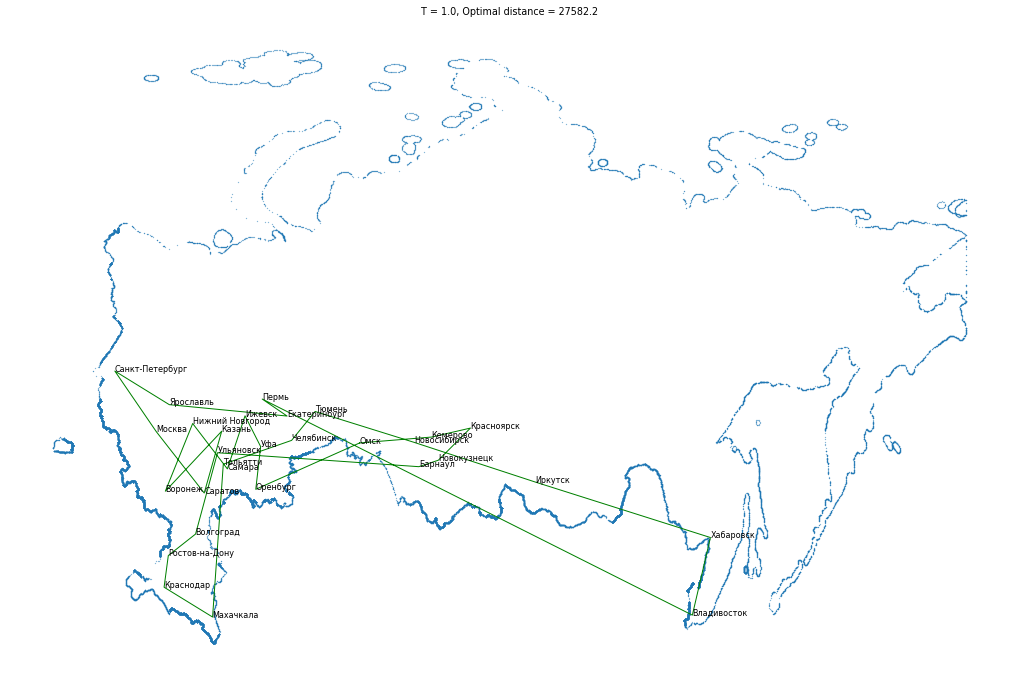

In [31]:
x = [i[0] for i in lat_lon]
y = [i[1] for i in lat_lon]

fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 8})
fig.set_size_inches(18, 12)

xs = []
ys = []

path = output[-1][0]
correct_path = correct_route(list(path))
temperature = output[-1][1]
d = dist(correct_path)

for j in range(len(correct_path)):
  city = correct_path[j]

  index = cities.index(city)

  xs.append(x[index])
  ys.append(y[index])

ax.clear()
ax.plot(ys, xs, linewidth=1, color='green')
ax.scatter(k, r, s=0.05)
ax.set_axis_off()

for j, txt in enumerate(cities):
  ax.annotate(txt, (y[j], x[j]))

ax.set_title('T = {}, Optimal distance = {}'.format(round(temperature, 1), round(d, 1)))